In [179]:
%reload_ext autoreload
%autoreload 2
    
from tqdm import tqdm
from copy import deepcopy
from pathlib import Path
import torch
import torch.nn as nn
from matplotlib import pyplot as plt
import numpy as np

import tasks
import models

from sklearn.decomposition import PCA
from rastermap import Rastermap

device = "cuda" if torch.cuda.is_available() else "cpu"

filepath = Path("~/Documents/Kempner/MCN2024/jobs/")
filepath = filepath.expanduser()

from analysis import load_job, load_results, load_weight_changes, equal_axes, perturb_parameter

In [68]:
jobid = 47
init_prms, final_prms = load_weight_changes(jobid)

jobids = [43, 44, 45, 46, 47]
cols = 'krbgm'
color = cols[jobids.index(jobid)]

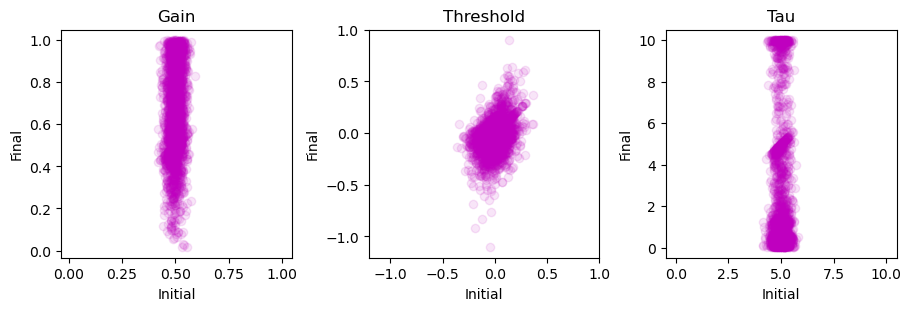

In [67]:

fig, ax = plt.subplots(1, 3, figsize=(9, 3), layout="constrained")
ax[0].scatter(init_prms["hidden_gain"], final_prms["hidden_gain"], c=color, alpha=0.1)
ax[0].set_xlabel("Initial")
ax[0].set_ylabel("Final")
ax[0].set_title("Gain")
equal_axes(ax[0])

ax[1].scatter(init_prms["hidden_threshold"], final_prms["hidden_threshold"], c=color, alpha=0.1)
ax[1].set_xlabel("Initial")
ax[1].set_ylabel("Final")
ax[1].set_title("Threshold")
equal_axes(ax[1])

ax[2].scatter(init_prms["hidden_tau"], final_prms["hidden_tau"], c=color, alpha=0.1)
ax[2].set_xlabel("Initial")
ax[2].set_ylabel("Final")
ax[2].set_title("Tau")
equal_axes(ax[2])

figure_name = "weight_changes"
plt.savefig(f"../project/{figure_name}_{jobid}")
plt.show()

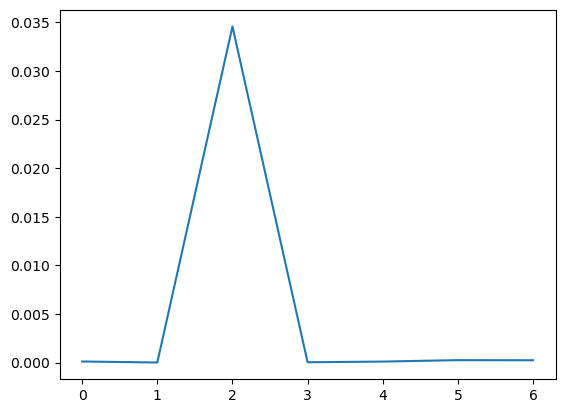

In [245]:
jobid = 48
train_loss, train_accuracy, train_evidence, train_fixation = load_results(jobid)

plt.close('all')
plt.plot(train_loss[:, -1])
plt.show()

In [246]:
# Load trained model and results

jobid = 48
model_index = 0
model, results, init_model = load_job(jobid, model_index=model_index, init=True)

args = results["args"]
task_params = results["task"]
train_loss = results["train_loss"]
train_accuracy = results["train_accuracy"]
train_evidence = results["train_evidence"]
train_fixation = results["train_fixation"]

task = tasks.ContextualGoNogo(
    args["input_dimensions"],
    args["end_sigma"],
    num_contexts=task_params["num_contexts"],
    stim_time=task_params["stim_time"],
    delay_time=args["end_delay"],
    decision_time=task_params["decision_time"],
    task_type=args["task_type"] if "task_type" in args else "embedded",
)
task.cursors = task_params["cursors"]

net = models.build_model(args, task)
net.load_state_dict(model)

<All keys matched successfully>

In [247]:
X, target, params = task.generate_data(10000, sigma=0.1, source_floor=0.5, source_strength=1.0)
output, hidden = net(X, return_hidden=True)
output = output.detach()

context_idx = params["context_idx"]
labels = params["labels"]

context_axis = (hidden[context_idx == 0].mean(dim=0) - hidden[context_idx == 1].mean(dim=0)).mean(dim=0).detach().numpy()
choice_axis = (hidden[labels == 0].mean(dim=0) - hidden[labels == 1].mean(dim=0)).mean(dim=0).detach().numpy()
context_axis /= np.linalg.norm(context_axis)
choice_axis /= np.linalg.norm(choice_axis)

all_hidden = np.array(hidden.view(-1, hidden.size(2)).detach()).T
pca = PCA(n_components=4).fit(all_hidden.T)
isort = torch.tensor(np.argsort(pca.components_[0]))

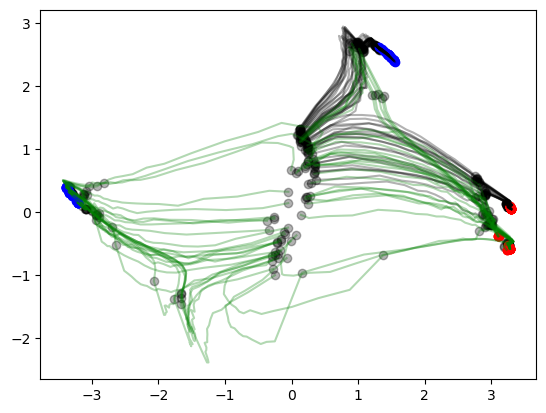

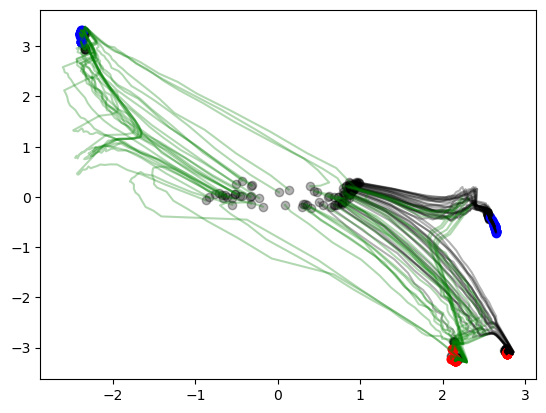

In [248]:
# task.decision_time = 
X, target, params = task.generate_data(100, source_floor=0.5, source_strength=1.5)
output, hidden = net(X, return_hidden=True)
output = output.detach()

decision_time = task.stim_time + task.delay_time

context_idx = params["context_idx"]
labels = params["labels"]

pc_hidden = hidden.detach().numpy() @ pca.components_.T[:, [0, 1]]

context_hidden = hidden.detach().numpy() @ context_axis
choice_hidden = hidden.detach().numpy() @ choice_axis

fig = plt.figure()
plt.plot(pc_hidden[context_idx==0, :, 0].T, pc_hidden[context_idx==0, :, 1].T, c='k', alpha=0.3)
plt.plot(pc_hidden[context_idx==1, :, 0].T, pc_hidden[context_idx==1, :, 1].T, c='g', alpha=0.3)
plt.scatter(pc_hidden[:, 0, 0], pc_hidden[:, 0, 1], c='k', alpha=0.3)
plt.scatter(pc_hidden[:, task.stim_time, 0], pc_hidden[:, task.stim_time, 1], c='k', alpha=0.3)
plt.scatter(pc_hidden[:, decision_time, 0], pc_hidden[:, decision_time, 1], c='k', alpha=0.3)
plt.scatter(pc_hidden[labels==0, -1, 0], pc_hidden[labels==0, -1, 1], c='b')
plt.scatter(pc_hidden[labels==1, -1, 0], pc_hidden[labels==1, -1, 1], c='r')
plt.show()

fig = plt.figure()
plt.plot(context_hidden[context_idx==0, :].T, choice_hidden[context_idx==0, :].T, c='k', alpha=0.3)
plt.plot(context_hidden[context_idx==1, :].T, choice_hidden[context_idx==1, :].T, c='g', alpha=0.3)
plt.scatter(context_hidden[:, 0], choice_hidden[:, 0], c='k', alpha=0.3)
plt.scatter(context_hidden[:, decision_time], choice_hidden[:, decision_time], c='k', alpha=0.3)
plt.scatter(context_hidden[labels==0, -1], choice_hidden[labels==0, -1], c='b')
plt.scatter(context_hidden[labels==1, -1], choice_hidden[labels==1, -1], c='r')
plt.show()

0 tensor(0., grad_fn=<MaxBackward1>)
1 tensor(0.3697, grad_fn=<MaxBackward1>)
2 tensor(0.6187, grad_fn=<MaxBackward1>)
3 tensor(0.9201, grad_fn=<MaxBackward1>)
4 tensor(0.9422, grad_fn=<MaxBackward1>)
5 tensor(1.5281, grad_fn=<MaxBackward1>)
6 tensor(1.8209, grad_fn=<MaxBackward1>)
7 tensor(1.8230, grad_fn=<MaxBackward1>)
8 tensor(2.0834, grad_fn=<MaxBackward1>)
9 tensor(2.5082, grad_fn=<MaxBackward1>)
10 tensor(2.9628, grad_fn=<MaxBackward1>)
11 tensor(3.5614, grad_fn=<MaxBackward1>)
12 tensor(4.6233, grad_fn=<MaxBackward1>)
13 tensor(5.9195, grad_fn=<MaxBackward1>)
14 tensor(7.2648, grad_fn=<MaxBackward1>)
15 tensor(9.0208, grad_fn=<MaxBackward1>)
16 tensor(12.3069, grad_fn=<MaxBackward1>)
17 tensor(15.9471, grad_fn=<MaxBackward1>)
18 tensor(21.3052, grad_fn=<MaxBackward1>)
19 tensor(27.9065, grad_fn=<MaxBackward1>)
20 tensor(37.5980, grad_fn=<MaxBackward1>)
21 tensor(52.1771, grad_fn=<MaxBackward1>)
22 tensor(71.6991, grad_fn=<MaxBackward1>)
23 tensor(98.0892, grad_fn=<MaxBackward1>

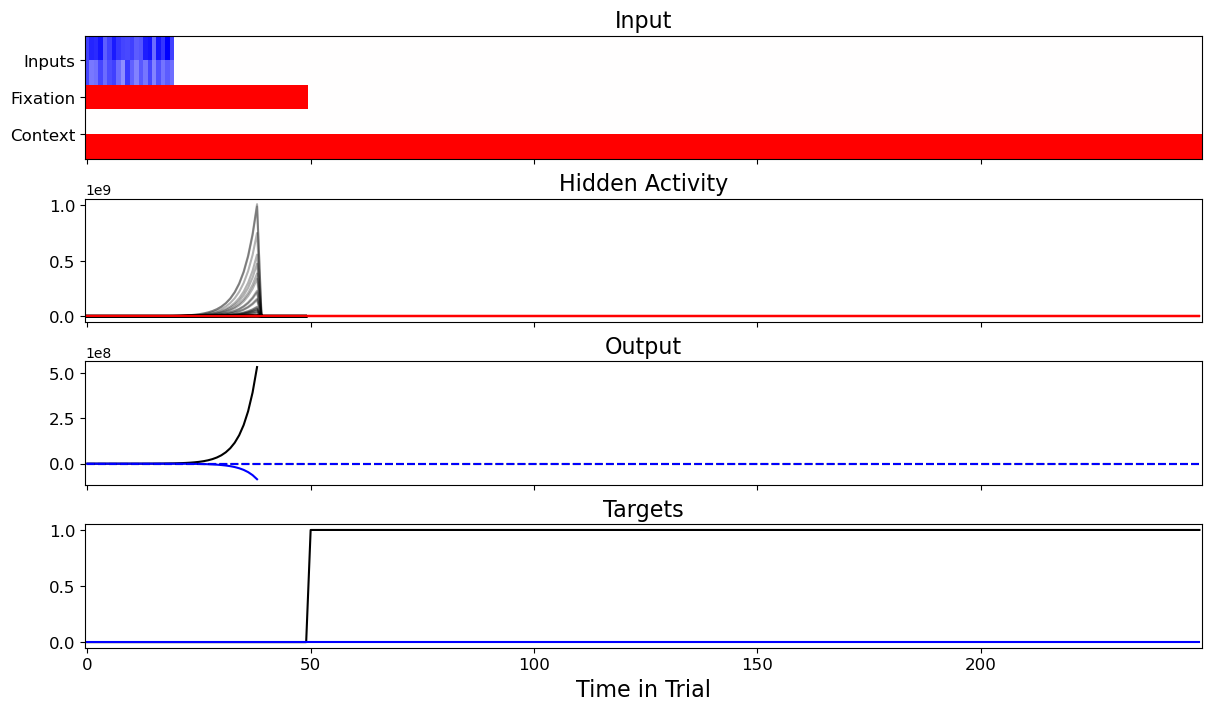

In [233]:
ibatch = 0

pnet = deepcopy(net)

targets = dict(
    gain="hidden_gain",
    threshold="hidden_threshold",
    tau="hidden_tau",
    receptive="reccurent_receptive",
    projective="reccurent_projective",
)

target_nonlinearity = dict(
    gain="sigmoid",
    threshold="linear",
    tau="sigmoid",
    receptive="linear",
    projective="linear",
)

do_perturb = True
if do_perturb:
    perturb_target = "tau"
    perturb_type = "rotation"
    perturb_ratio = np.pi/4

    old_parameter = getattr(pnet, targets[perturb_target])
    old_parameter = old_parameter.data
    if target_nonlinearity[perturb_target] == "sigmoid":
        old_parameter = torch.sigmoid(old_parameter)
    
    new_parameter = perturb_parameter(old_parameter, perturb_ratio, perturb_type)

    if target_nonlinearity[perturb_target] == "sigmoid":
        new_parameter = torch.clamp(new_parameter, 1e-6, 1 - 1e-6)
        new_parameter = torch.log(new_parameter / (1 - new_parameter))

    attribute = getattr(pnet, targets[perturb_target])
    attribute.data = new_parameter

task.decision_time = 200
X, target, params = task.generate_data(1, source_floor=0.1, source_strength=1.0, sigma=0.1)
output, hidden, xx_in, rr_in, dh_in = pnet(X, return_hidden=True, return_currents=True)
output_standard, hidden_standard = net(X, return_hidden=True)
output = output.detach()
output_standard = output_standard.detach()

fontsize = 16
smallfont = 12
fig, ax = plt.subplots(4, 1, figsize=(12, 7), layout="constrained", sharex=True)
ax[0].imshow(X[ibatch].T, aspect="auto", cmap="bwr", interpolation="none", vmin=-1, vmax=1)
ax[0].set_yticks([0.5, 2, 3.5], labels=["Inputs", "Fixation", "Context"], fontsize=smallfont)
ax[0].set_title("Input", fontsize=fontsize)
ax[1].plot(hidden[ibatch].detach().numpy()[:, isort], c='k', alpha=0.3)
ax[1].plot(hidden_standard[ibatch].detach().numpy()[:, isort], c='r', alpha=0.1)
# ax[1].imshow(hidden[ibatch].detach().numpy().T[isort], aspect="auto", interpolation="none", cmap='gray')
ax[1].tick_params(axis="y", labelsize=smallfont)
ax[1].set_title("Hidden Activity", fontsize=fontsize)
ax[2].plot(output[ibatch].detach().numpy()[:, 0], c='k')
ax[2].plot(output[ibatch].detach().numpy()[:, 1], c='b')
ax[2].plot(output_standard[ibatch][:, 0].detach().numpy(), label="Network Output", c='k', linestyle='--')
ax[2].plot(output_standard[ibatch][:, 1].detach().numpy(), label="Network Output", c='b', linestyle='--')
ax[2].set_title("Output", fontsize=fontsize)
# ax[2].set_yticks([0, 1])
ax[2].tick_params(axis="y", labelsize=smallfont)
ax[3].plot(target[ibatch][:, 0].detach().numpy(), label="Target", c='k')
ax[3].plot(target[ibatch][:, 1].detach().numpy(), label="Target", c='b')
ax[3].set_title("Targets", fontsize=fontsize)
ax[3].set_xlabel("Time in Trial", fontsize=fontsize)
# ax[3].set_yticks([0, 1])
ax[3].tick_params(axis="y", labelsize=smallfont)
ax[3].tick_params(axis='x', labelsize=smallfont)
plt.show()